# Librerias

In [19]:
import dataAcquisition
import ReparameterizationTrick
import Encoder
import Decoder
import VAE
import loss
import train
import Predictor
import importlib
import numpy as np

#

# Data adquisition

In [20]:
importlib.reload(dataAcquisition)
#x_train, x_val, y_train, y_val, average_image_train, x_train_mixed, x_test_mixed, x_train_perm, y_train_perm

x_train, x_val, y_train, y_val, average_image, x_train_mix, x_test_mix,x_train_1, y_train_1 =  dataAcquisition.data_acquisition()

x_train(60k).shape:       (60000, 28, 28)
x_train_C.shape:     (55000, 28, 28, 1)
x_val_C.shape:     (5000, 28, 28, 1)
x_test_C.shape:      (10000, 28, 28, 1)
x_train.shape:       (55000, 28, 28)
x_val.shape:       (5000, 28, 28)
x_test.shape:       (10000, 28, 28)
x_train_mix.shape:  (55000, 28, 28)
x_test_mix.shape:  (10000, 28, 28)


# Encoder

In [21]:
importlib.reload(Encoder)
encoder = Encoder.encoder(x_train, y_train, latent_dim=2)


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 784)       │          0 │ input_img[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_condition   │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 794)       │          0 │ flatten_3[0][0],  │
│ (Concatenate)       │                   │            │ encoder_conditio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │    101,760 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        258 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        258 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_2          │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 102,276 (399.52 KB)

 Trainable params: 102,276 (399.52 KB)

 Non-trainable params: 0 (0.00 B)

# Decoder


In [22]:
importlib.reload(Decoder)
decoder = Decoder.decoder(x_train, y_train,latent_dim=2)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ z_sampling          │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_condition   │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 12)        │          0 │ z_sampling[0][0], │
│ (Concatenate)       │                   │            │ decoder_conditio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │      1,664 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 784)       │    101,136 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 28, 28, 1) │          0 │ dense_9[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 102,800 (401.56 KB)

 Trainable params: 102,800 (401.56 KB)

 Non-trainable params: 0 (0.00 B)

VAE

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_condition   │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ [(None, 2),       │    102,276 │ input_img[0][0],  │
│ (Functional)        │ (None, 2), (None, │            │ encoder_conditio… │
│                     │ 2)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_condition   │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 28, 28, 1) │    102,800 │ encoder[0][2],    │
│ (Functional)        │                   │            │ decoder_conditio… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 205,076 (801.08 KB)

 Trainable params: 205,076 (801.08 KB)

 Non-trainable params: 0 (0.00 B)

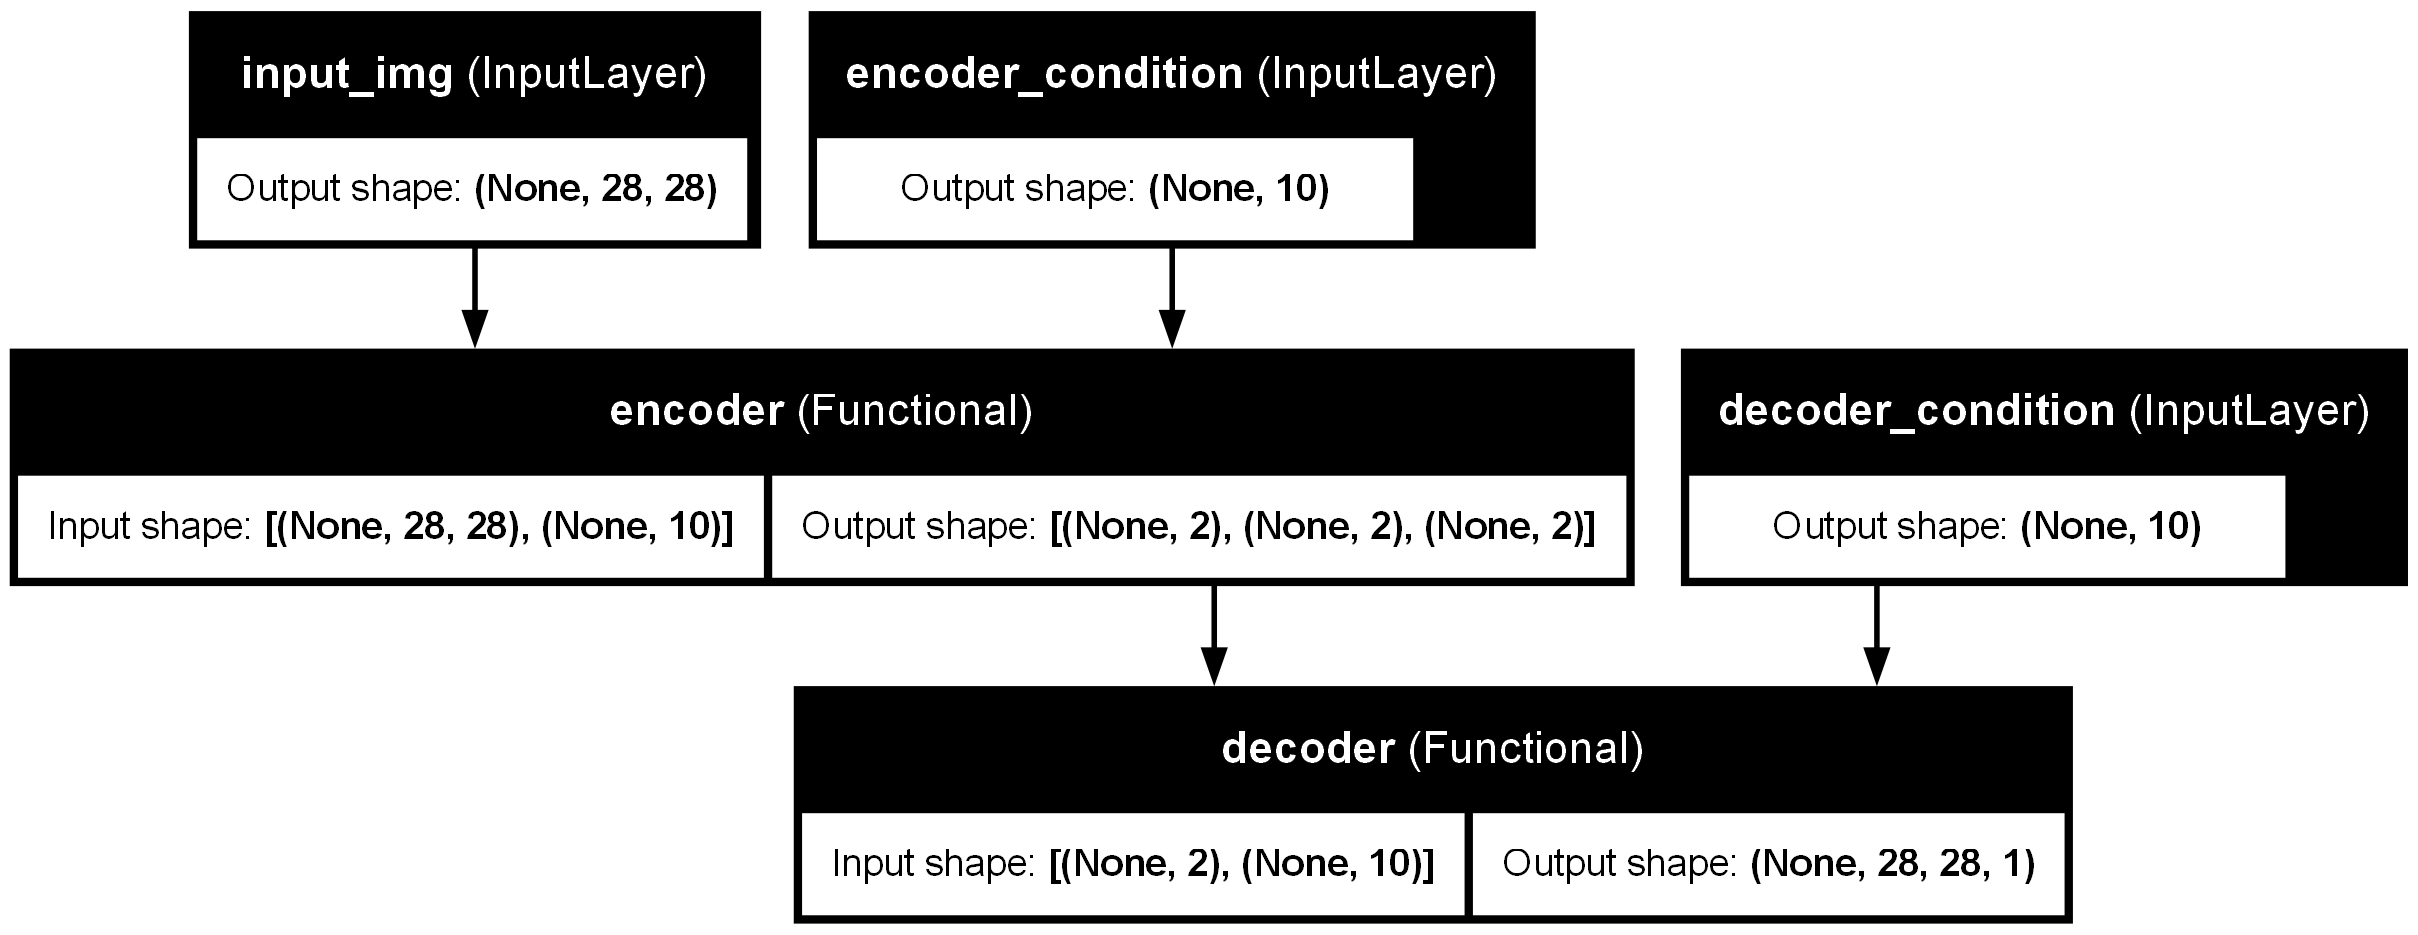

In [23]:
importlib.reload(VAE)
n_cond = np.shape(y_train)[1]  
vae =  VAE.Vae(encoder,decoder, show_model=True)

# Compile

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


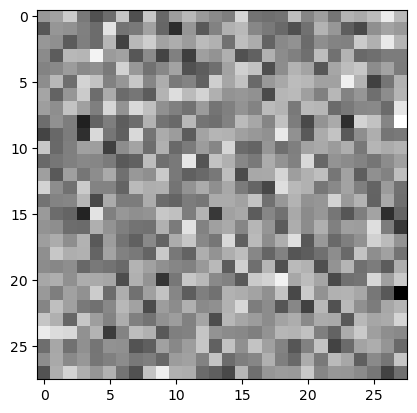

In [24]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
importlib.reload(loss)
# Optimizer ------------------------------------------------------------------
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Compile --------------------------------------------------------------------
vae.compile(optimizer, loss=loss.vae_loss) #cambiar nombre

img = np.expand_dims(x_train[0], axis=0)
cond = np.expand_dims(y_train[0], axis=0)
salida = vae.predict([img, cond,cond])

reconstruccion = salida[0].reshape(28, 28)
plt.imshow(reconstruccion, cmap='gray')

# Train

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 68.4725 - val_loss: 39.1020
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


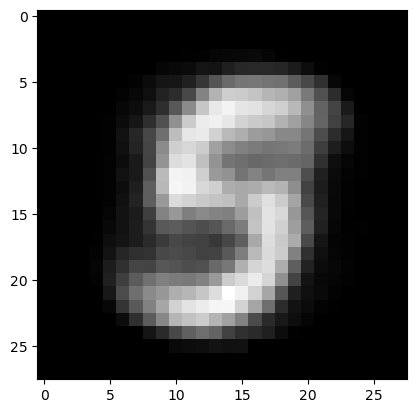

430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 38.5058 - val_loss: 35.0938
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


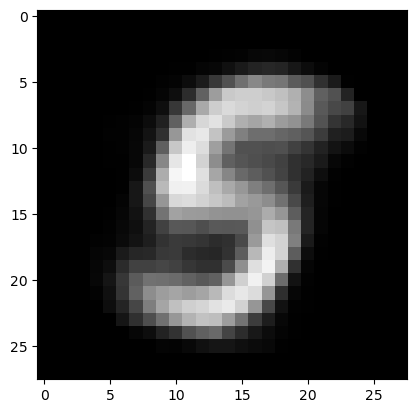

430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 35.4546 - val_loss: 33.7403
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


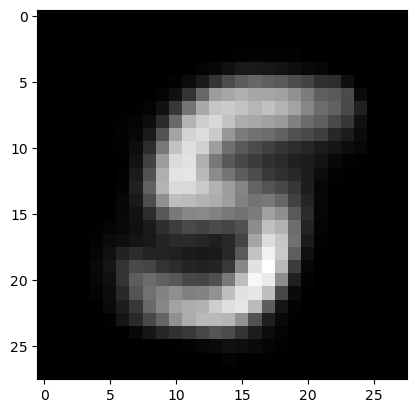

430/430 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 34.0826 - val_loss: 32.8702
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


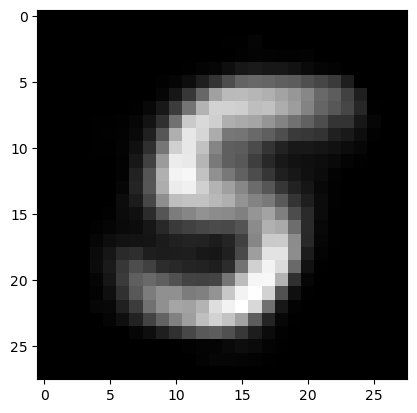

430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 33.3051 - val_loss: 32.2233
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


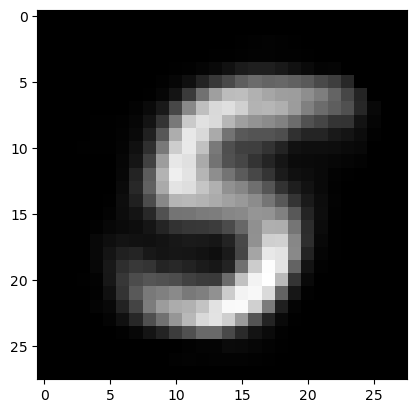

In [25]:
salida = vae.predict([img, cond,cond])
reconstruccion = salida[0].reshape(28, 28)
plt.imshow(reconstruccion, cmap='gray')

for i in range(5):
    train.train(vae, x_train, y_train, x_val, y_val)
    salida = vae.predict([img, cond,cond])
    reconstruccion = salida[0].reshape(28, 28)
    plt.imshow(reconstruccion, cmap='gray')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


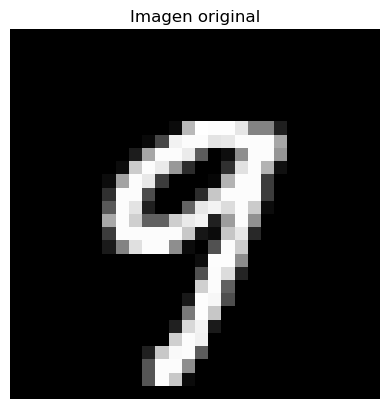

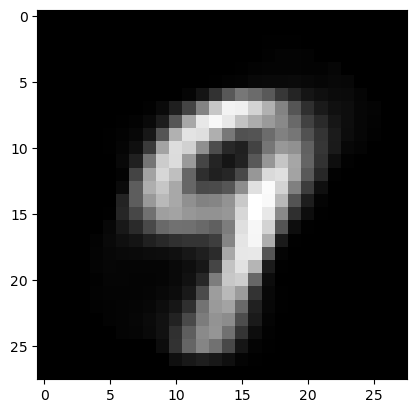

In [26]:
img = np.expand_dims(x_train[45], axis=0)
cond = np.expand_dims(y_train[45], axis=0)
salida = vae.predict([img, cond,cond])

reconstruccion = salida[0].reshape(28, 28)
plt.imshow(img[0], cmap='gray')
plt.title("Imagen original")
plt.axis('off')
plt.show()
plt.imshow(reconstruccion, cmap='gray')

Model: "predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ original_input (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_layer_49 (ReshapeLayer) │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │        31,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,186 (196.04 KB)

 Trainable params: 50,186 (196.04 KB)

 Non-trainable params: 0 (0.00 B)

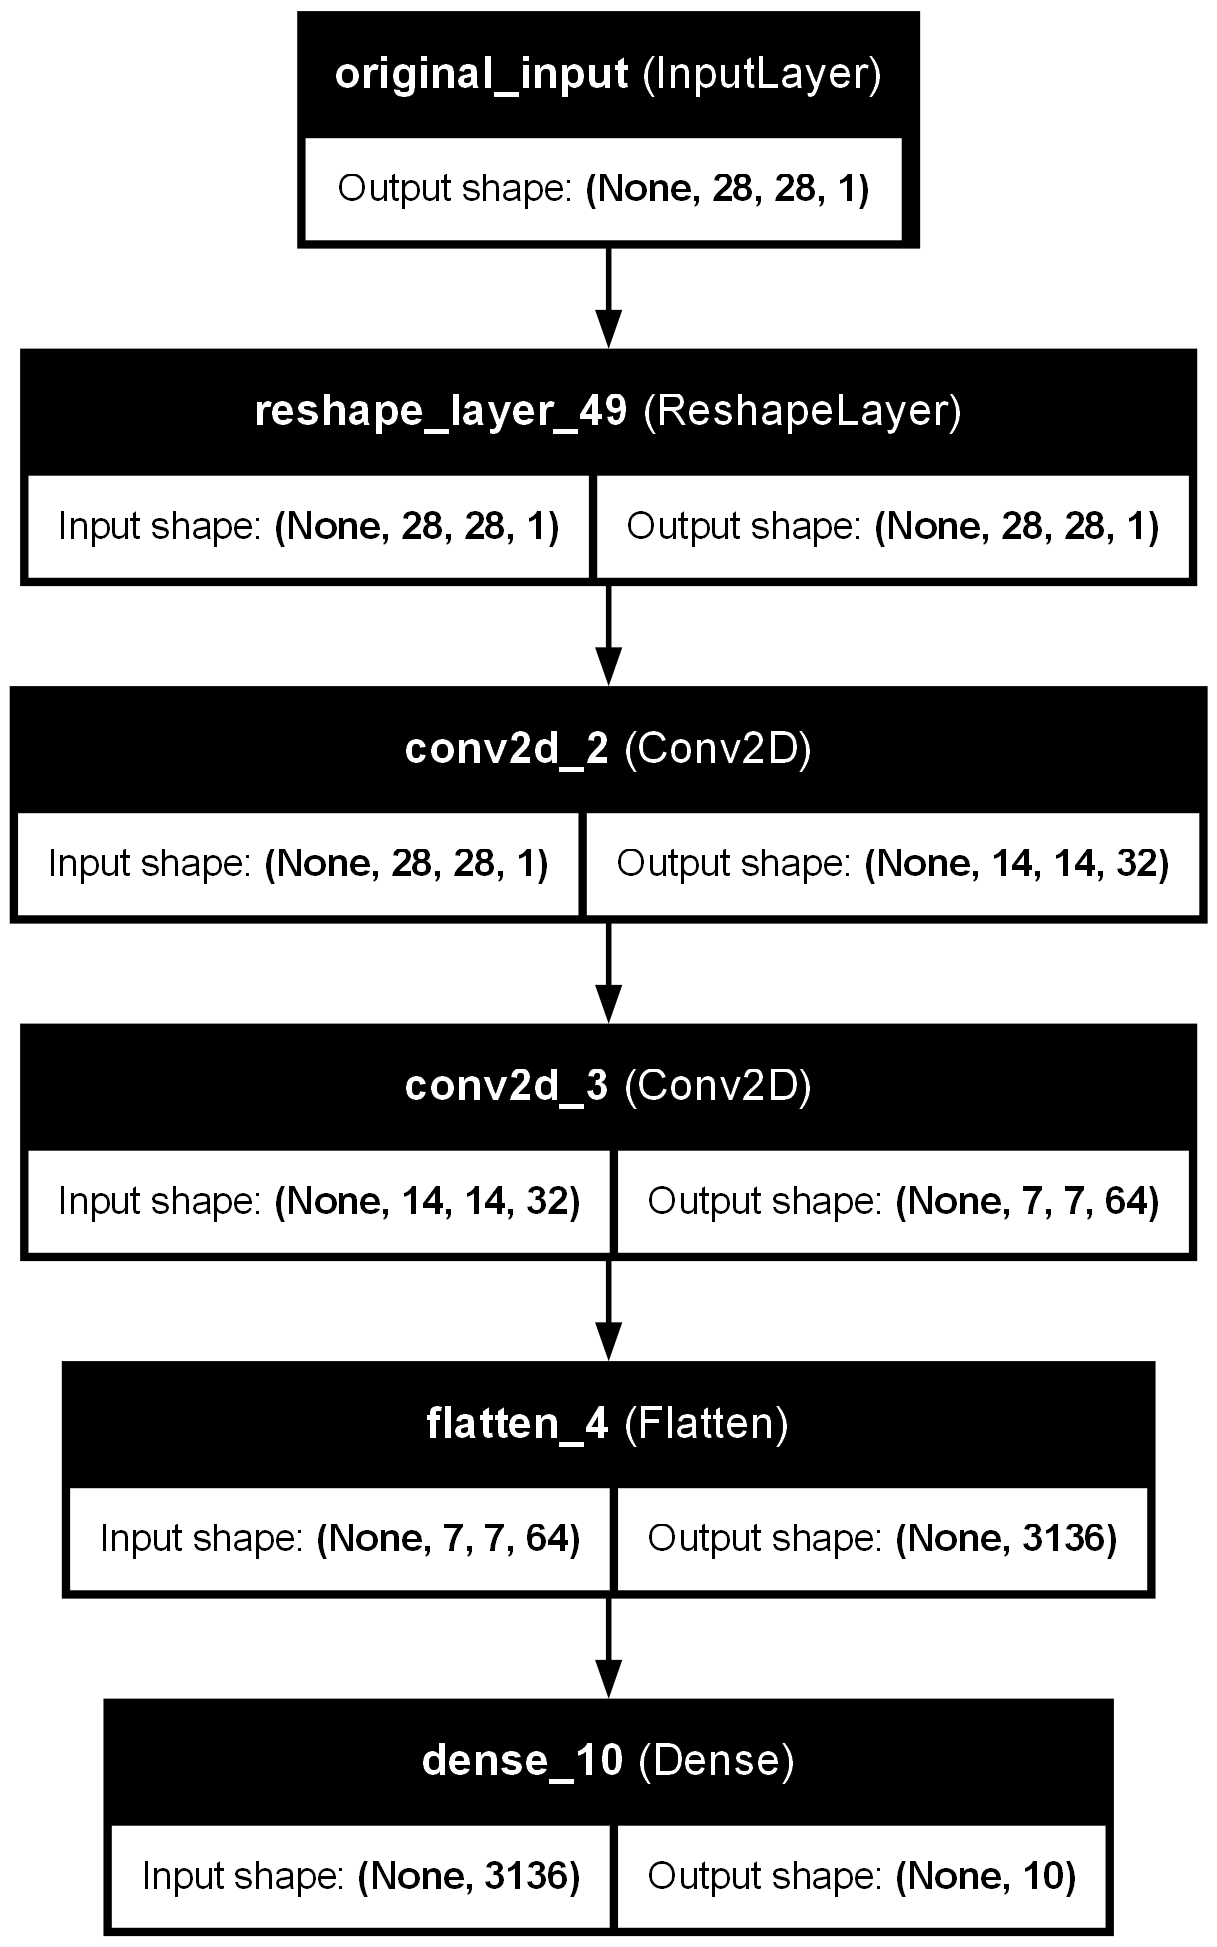

In [27]:
importlib.reload(Predictor)
predictor_c = Predictor.predictor()

(1, 28, 28)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


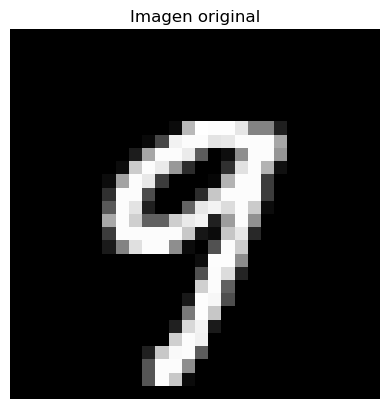

In [28]:
importlib.reload(Predictor)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
predictor_c.compile(optimizer, loss="categorical_crossentropy")
print(img.shape)
prediccion = np.argmax( predictor_c.predict(img))
img[0].reshape(28, 28)
plt.imshow(img[0], cmap='gray')
plt.title("Imagen original")
plt.axis('off')
plt.show()


In [29]:
for i in range(5): 
    #reconstruccion = prediccion[0].reshape(28, 28)
    print(f"prediccion  {prediccion}")
    prediccion = np.argmax(predictor_c.predict(img))


    predictor_c.fit(
        x=x_train,
        y=y_train,
        batch_size=128,
        epochs=1,
        validation_data=(x_val, y_val)  # Include validation data
        )

prediccion  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.6967 - val_loss: 0.1088
prediccion  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.1131 - val_loss: 0.0705
prediccion  9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0725 - val_loss: 0.0559
prediccion  9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0555 - val_loss: 0.0585
prediccion  9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 0.0455 - val_loss: 0.0566


(28, 28)


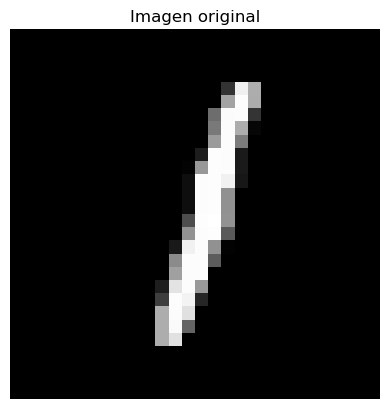

In [30]:

plt.imshow(x_train_1[0], cmap='gray')
print(x_train_1[0].shape)
plt.title("Imagen original")
plt.axis('off')
plt.show()


(55000, 28, 28)
(1, 28, 28)


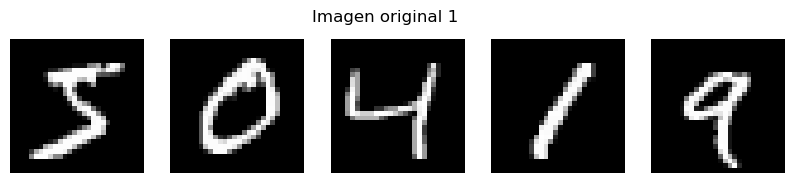

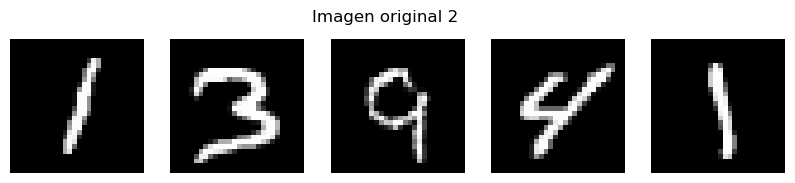

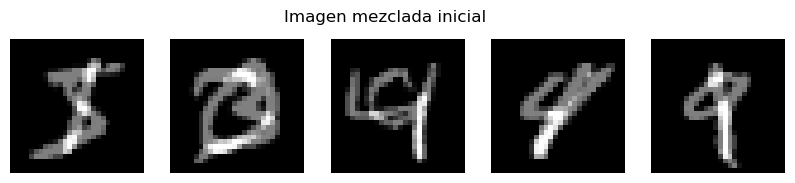

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
ITERACIÓN A: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
tf.Tensor(
[0.4993932  0.25363606 0.43971097 0.5008665  0.6460125  0.6336637
 0.16302246 0.7925317  0.23624681 0.42536893], shape=(10,), dtype=float32)
tf.Tensor(
[0.3553434  0.14065674 0.5871587  0.57694954 0.34580633 0.45740086
 0.22152124 0.6783339  0.32211915 0.42323002], shape=(10,), dtype=float32)
tf.Tensor(
[0.42736828 0.1971464  0.5134348  0.538908   0.4959094  0.5455323
 0.19227186 0.7354328  0.27918297 0.42429948], shape=(10,), dtype=float32)
tf.Tensor(
[0.52482265 0.8297015  0.44223973 0.32329726 0.49285266 0.6600486
 0.38012633 0.23262088 0.47849122 0.39019826], shape=(10,), dtype=float32)
tf.Tensor(
[0.41375512 0.61428976 0.69332314 0.5532975  0.35093436 0.49670815
 0.57535994 0.19985905 0.8171

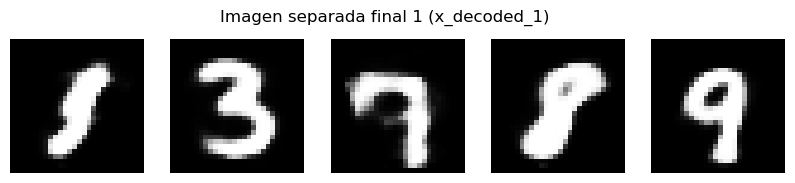

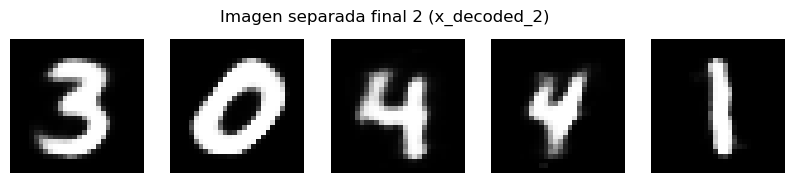

In [31]:
import inferencias
importlib.reload(inferencias)
#importlib.reload(outcomes)
print(x_train.shape)
import inferencias

# Suponiendo que ya tienes definidos:
# x_train, x_train_1, y_train, y_train_1, predictor, encoder, decoder

print(x_train[0:1].shape) #analizar por que se rompe con una sola imagen

inferencias.inferncia_modelo(x_train[0:10], x_train_1[0:10], y_train[0:10], predictor_c, encoder, decoder, y_train_1[0:10],vae)